# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на новые тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Нужно построить модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75 и проверить *accuracy* на тестовой выборке.

1. [Изучение файла](#Изучение-файла)
2. [Разобъём данные на выборки](#Разобъём-данные-на-выборки)
3. [Исследуем модели](#Исследуем-модели)
4. [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке)
5. [Проверка модели на адекватность](#Проверка-модели-на-адекватность)
6. [Вывод](#Вывод)

## Изучение файла

Посмотрим на наши данные.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("users_behavior.csv")

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.shape

(3214, 5)

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц:


* сalls — количество звонков;
* minutes — суммарная длительность звонков в минутах;
* messages — количество sms-сообщений;
* mb_used — израсходованный интернет-трафик в Мб;
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим на целевой столбец *is_ultra*, какая доля пользователей с одним и другим тарифом.

In [5]:
df['is_ultra'].mean()

0.30647168637212197

Почти 31% пользователей подключен к тарифу «Ультра», а пользователей со «Смартом» 69% соответственно.

## Разобъём данные на выборки

Для начала мы определим признаки и цели в нашей выборке.

In [6]:
features = df.drop(['is_ultra'], axis=1) 
target = df['is_ultra']

Проверим, что находится в каждой переменной.

In [7]:
features.head()

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75


In [8]:
target.head()

0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

Поскольку у нас нет тестовой выборки, на которой в последствии мы можем проверить, как хорошо обучилась модель, то нам её нужно взять из наших данных. Разделим выборку на ту, что пойдёт для обучения, и тестовую, взяв 20% для последней.

In [9]:
features_model, features_test, target_model, target_test = \
train_test_split(features, target, test_size=0.2, random_state=42)

Проверим размер получившихся  выборок.

In [10]:
features_model.shape, features_test.shape

((2571, 4), (643, 4))

Теперь данные для обучения разделим на тренировочные и валидационные, также взяв 20% для проверки.

In [11]:
features_train, features_valid, target_train, target_valid = \
train_test_split(features_model, target_model, test_size=0.2, random_state=42)

Снова проверим размер выборок.

In [12]:
features_train.shape, features_valid.shape

((2056, 4), (515, 4))

Сложим количество объектов тренировочной, валидационной и тестовой выборок, для проверки.

In [13]:
features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == df.shape[0]

True

Исходное количество объектов совпадает с подготовленным количеством объектов для обучения и проверки.

## Исследуем модели

Существует несколько алгоритмов, в нашем случае алгоритмов классификации, для обучения моделей: **дерево решений**, **случайный лес** и **логистическая регрессия**. Рассмотрим все алгоритмы и начнём с **дерева решений**.

Получим модель с алгоритмом **дерева решений** и обучим её.

In [14]:
model = DecisionTreeClassifier(random_state=42)

In [15]:
model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=42)

Сравним результаты того, как модель предсказывает на обучающей и валидационной выборках.  Используем критерий точности *accuracy*.

In [16]:
train_predictions = model.predict(features_train)
valid_predictions = model.predict(features_valid)

In [17]:
train_accuracy = accuracy_score(target_train, train_predictions)
valid_accuracy = accuracy_score(target_valid, valid_predictions)

In [18]:
train_accuracy

1.0

In [19]:
valid_accuracy

0.7009708737864078

Мы видим, что точность на обучающей выборке 100%. Точность на валидационной выборке поменьше - 70%. По данным значениям мы можем сказать, что наша модель переобучилась. Однако такой точности на валидационной выборке недостаточно, на последующих данных, которые будет принимать наша модель, точно снизится ещё больше.

У **дерева решений** есть гиперпараметры: *максимальной глубины*, *минимальное количество примеров для разделения* (по умолчанию 2), *минимальное количество объектов в листе* (по умолчанию 1). Подберём такие параметры, при которых, точность нашей модели будет максимальной. Проверим качество на обучающих данных.

In [20]:
def best_model(feature, target):
    best_model_ = None
    best_result_ = 0
    for depth in range(1, 11):
        for sample in range(2, 6):
            for leaf in range(1, 6):
                model_ = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_split=sample, min_samples_leaf=leaf)
                model_.fit(features_train, target_train)
                predictions = model_.predict(feature)
                result = accuracy_score(target, predictions)
                if result > best_result_:
                    best_model_ = model_
                    best_result_ = result
    return best_model_, best_result_

In [21]:
best_model(features_train, target_train)

(DecisionTreeClassifier(max_depth=10, random_state=42), 0.8852140077821011)

Мы видим, что максимальная точность 88,5% при максимальном параметре *max_depth* и стандартных параметрах *min_samples_split* и *min_samples_leaf*. Это и естественно, чем больше ветвей, тем точнее предсказание.

Теперь проверим, какие параметры дают макстимальную точность уже на валидационной выборке.

In [22]:
best_result_dtc = best_model(features_valid, target_valid)
best_result_dtc

(DecisionTreeClassifier(max_depth=3, random_state=42), 0.7980582524271844)

На валидационной выборке достаточно трёх ветвей, для более точных результатов. Процент точности предсказаний в таком случае равен 80%, остальные параметрых также лучше стандартные.

Теперь построим модель и найдём наилучшую точность на валидационной выборке используя **случайный лес**. У этого алгоритма есть и ещё гиперпараметр: *n_estimators*, отражающий количество деревьев. Узнаем, при каких параметрах точность выше.

In [23]:
best_model_rfc = None
best_result_rfc = 0
for est in range(1, 11):
    for depth in range(1, 11):
        for leaf in range(1, 6):
            model_rfc = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, min_samples_leaf=leaf)
            model_rfc.fit(features_train, target_train)
            result_rfc = model_rfc.score(features_valid, target_valid)
            if result_rfc > best_result_rfc:
                best_model_rfc = model_rfc
                best_result_rfc = result_rfc

In [24]:
best_model_rfc

RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=5,
                       random_state=42)

In [25]:
best_result_rfc

0.8233009708737864

Максимальная точность на валидационной выборке равна 82%. Это достигается при 5 деревьях, максимальной глубине 8 и при 2 выборках в алгоритме модели. Правда считает такая модель дольше.

Теперь узнаем точность модели при алгоритме **логистической регрессии**. У неё нет гиперпараметров, поэтому вероятность переобучения мала.

In [26]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(features_train, target_train)
result_lr = model_lr.score(features_valid, target_valid)

In [27]:
result_lr

0.7165048543689321

Модель построенная на **логистической регрессии** даёт точность предсказаний в 75%.

Сравним полученные модели.

In [28]:
versus = pd.DataFrame({'model': ['Дерево решений', 'Случайный лес', 'Логистическая регрессия'],
                       'accuracy': [best_result_dtc[1], best_result_rfc ,result_lr]})
versus

,model,accuracy
0,Дерево решений,0.798058
1,Случайный лес,0.823301
2,Логистическая регрессия,0.716505


Наибольшую точность предсказаний даёт **случайный лес** с тремя ветвями - 82%. Хуже всех справилась **логистическая регрессия** - 72%.

## Проверка модели на тестовой выборке

Теперь проверим на тестовой выборке, нашу лучшую модель.

In [29]:
best_model_rfc
predictions_test = best_model_rfc.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
result_test

0.8102643856920684

Наша модель с алгоритмом **случайный лес** на тестовой выборке выдаёт точность 81%, что сопоставима с точностью на валидационной выборке. А значит теперь мы можем предсказать, какой тариф наиболее подходит пользователям.

## Проверка модели на адекватность

Проверим наши модели на адекватность.

In [30]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(features_train, target_train)
dummy_predict = dummy_clf.predict(features_valid)

In [31]:
score_clf = dummy_clf.score(features_test, target_test)
score_clf

0.7076205287713841

Фиктивная точность предсказания на тестовой выборке - 71%. Проверим наши модели.

In [32]:
score_dtc = best_result_dtc[0].score(features_test, target_test)
score_rfc = best_model_rfc.score(features_test, target_test)
score_lr = model_lr.score(features_test, target_test)

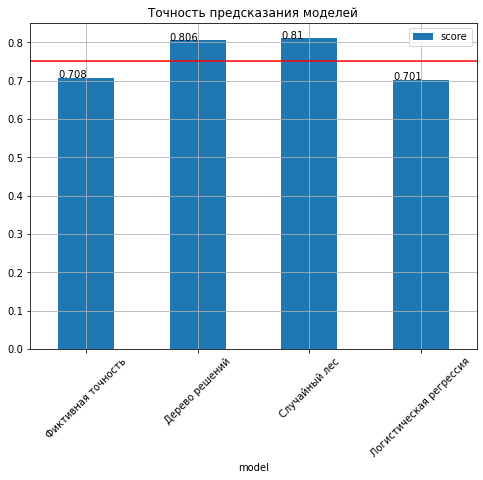

In [33]:
vs = pd.DataFrame({'model': ['Фиктивная точность', 'Дерево решений', 'Случайный лес', 'Логистическая регрессия'],\
                   'score': [score_clf, score_dtc, score_rfc ,score_lr]})
ax = vs.plot(kind='bar', x='model', grid=True, figsize=(8,6), rot=45, title="Точность предсказания моделей");
for p in ax.patches:
    ax.annotate(str(p.get_height().round(3)), (p.get_x(), p.get_height()))
plt.axhline(y=0.75, color='r', linestyle='-')
plt.show()

Как мы видим не все наши модели выдают результат выше фиктивной точности, **логистическая регрессия** оказалася менее адекватной моделью с точность в 70%. Самой адекватной моделью является **случайный лес** с точностью в 81%, на десятые доли процентов отстаёт и **дерево решений**.

## Вывод

Мы рассмотрели предоставленные данные и:
* разбили выборку на признаки и целевой признак, а также выделим обучающую, валидационную и тестовую выборки в соотношении 60/20/20%.
* исследовав разные модели мы пришли к выводу, что лучшей моделью на валидационной выборке стала модель **случайного леса** с точностью предсказаний 82%. **Дерево решений** показало точность 80%, а **логистическая регрессия** - 72%.
* лучшая модель на тестовой выборке показала точность в 81%, что соответствует поставленной задаче.
* проверка на адекватность показала, что **логистическая регрессия** показала точность чуть хуже фиктивной модели, а остальные две модели показали результаты гораздо выше фиктивной.